# Netlist Cleaning

> Graph Analysis and cleaning of a SAX Netlist

In [2]:
from collections import defaultdict
from typing import Dict, List

from natsort import natsorted
from sax.backends.additive import graph_edges
from sax.typing_ import SDict
import networkx as nx

try:
    import jax.numpy as jnp
    JAX_AVAILABLE = True
except ImportError:
    import numpy as jnp
    JAX_AVAILABLE = False

In [3]:
netlist = {
    "instances": {
        "lft": "coupler",
        "top": "straight",
        "btm": "straight",
        "rgt": "coupler",
        "lft_": "coupler",
        "top_": "straight",
        "btm_": "straight",
        "rgt_": "coupler",
    },
    "connections": {
        "lft,out0": "btm,in0",
        "btm,out0": "rgt,in0",
        "lft,out1": "top,in0",
        "top,out0": "rgt,in1",
        "lft_,out0": "btm_,in0",
        "btm_,out0": "rgt_,in0",
        "lft_,out1": "top_,in0",
        "top_,out0": "rgt_,in1",
    },
    "ports": {
        "in0": "lft,in0",
        "in1": "lft,in1",
        "out0": "rgt,out0",
        "out1": "rgt,out1",
    },
}

In [4]:
def _get_connectivity_netlist(netlist):
    connectivity_netlist = {
        "instances": natsorted(netlist["instances"]),
        "connections": [
            (c1.split(",")[0], c2.split(",")[0])
            for c1, c2 in netlist["connections"].items()
        ],
        "ports": [(p, c.split(",")[0]) for p, c in netlist["ports"].items()],
    }
    return connectivity_netlist

In [5]:
def _get_connectivity_graph(netlist):
    graph = nx.Graph()
    connectivity_netlist = _get_connectivity_netlist(netlist)
    for name in connectivity_netlist["instances"]:
        graph.add_node(name)
    for c1, c2 in connectivity_netlist["connections"]:
        graph.add_edge(c1, c2)
    for c1, c2 in connectivity_netlist["ports"]:
        graph.add_edge(c1, c2)
    return graph

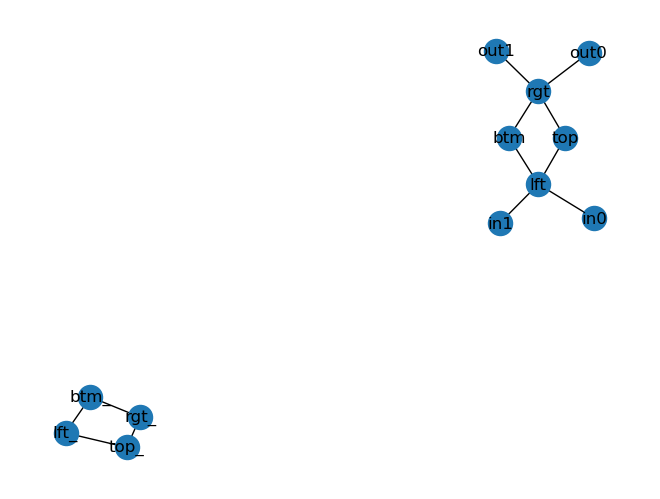

In [6]:
graph = _get_connectivity_graph(netlist)
nx.draw(graph, with_labels=True)

In [7]:
def _get_nodes_to_remove(graph, netlist):
    nodes = set()
    for port in netlist["ports"]:
        nodes |= nx.descendants(graph, port)
    nodes_to_remove = set(graph.nodes) - nodes
    return list(nodes_to_remove)

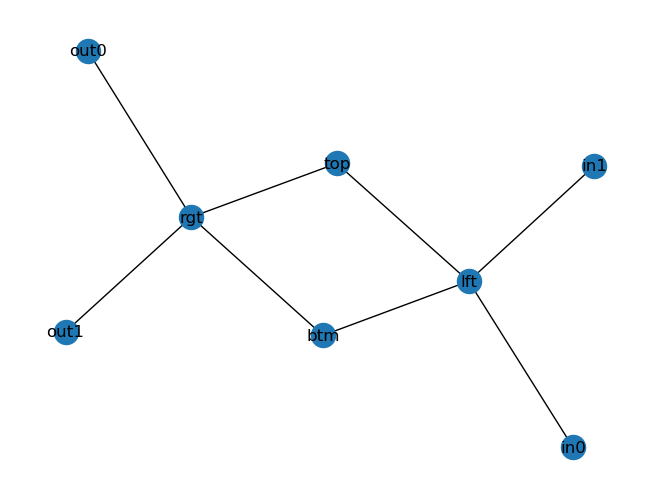

In [8]:
graph.remove_nodes_from(_get_nodes_to_remove(graph, netlist))
nx.draw(graph, with_labels=True)

In [9]:
def _remove_unused_instances_flat(flat_netlist):
    flat_netlist = {**flat_netlist}

    flat_netlist["instances"] = {**flat_netlist["instances"]}
    flat_netlist["connections"] = {**flat_netlist["connections"]}
    flat_netlist["ports"] = {**flat_netlist["ports"]}

    graph = _get_connectivity_graph(flat_netlist)
    names = set(_get_nodes_to_remove(graph, flat_netlist))

    for name in list(names):
        if name in flat_netlist["instances"]:
            del flat_netlist["instances"][name]

    for conn1, conn2 in list(flat_netlist["connections"].items()):
        for conn in [conn1, conn2]:
            name, _ = conn.split(",")
            if name in names and conn1 in flat_netlist["connections"]:
                del flat_netlist["connections"][conn1]

    for pname, conn in list(flat_netlist["ports"].items()):
        name, _ = conn.split(",")
        if name in names and pname in flat_netlist["ports"]:
            del flat_netlist["ports"][pname]

    return flat_netlist

In [10]:
_remove_unused_instances_flat(netlist)

{'instances': {'lft': 'coupler',
  'top': 'straight',
  'btm': 'straight',
  'rgt': 'coupler'},
 'connections': {'lft,out0': 'btm,in0',
  'btm,out0': 'rgt,in0',
  'lft,out1': 'top,in0',
  'top,out0': 'rgt,in1'},
 'ports': {'in0': 'lft,in0',
  'in1': 'lft,in1',
  'out0': 'rgt,out0',
  'out1': 'rgt,out1'}}

:::{eval-rst}
.. autofunction:: sax.netlist_cleaning.remove_unused_instances
:::


In [11]:
def remove_unused_instances(recursive_netlist):
    recursive_netlist = {**recursive_netlist}

    for name, flat_netlist in recursive_netlist.items():
        recursive_netlist[name] = _remove_unused_instances_flat(flat_netlist)

    return recursive_netlist

In [12]:
remove_unused_instances({"top_level": netlist, "test": netlist})

{'top_level': {'instances': {'lft': 'coupler',
   'top': 'straight',
   'btm': 'straight',
   'rgt': 'coupler'},
  'connections': {'lft,out0': 'btm,in0',
   'btm,out0': 'rgt,in0',
   'lft,out1': 'top,in0',
   'top,out0': 'rgt,in1'},
  'ports': {'in0': 'lft,in0',
   'in1': 'lft,in1',
   'out0': 'rgt,out0',
   'out1': 'rgt,out1'}},
 'test': {'instances': {'lft': 'coupler',
   'top': 'straight',
   'btm': 'straight',
   'rgt': 'coupler'},
  'connections': {'lft,out0': 'btm,in0',
   'btm,out0': 'rgt,in0',
   'lft,out1': 'top,in0',
   'top,out0': 'rgt,in1'},
  'ports': {'in0': 'lft,in0',
   'in1': 'lft,in1',
   'out0': 'rgt,out0',
   'out1': 'rgt,out1'}}}